In [5]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)

df = pd.read_csv("../data/post-operative-data.csv")


In [6]:
df['decision ADM-DECS'] = df['decision ADM-DECS'].str.strip()
df = df[df['decision ADM-DECS'].isin(['A', 'S'])]
df = df.rename(columns={"decision ADM-DECS": "decision"})


In [7]:
df.columns = (
    df.columns
    .str.lower()
    .str.replace("-", "_")
    .str.strip()
)

In [8]:
df['comfort'] = df['comfort'].replace('?', np.nan)
df['comfort'] = df['comfort'].astype(float)
df['comfort'] = df['comfort'].fillna(df['comfort'].median())

In [9]:
df.isna().sum()


l_core       0
l_surf       0
l_o2         0
l_bp         0
surf_stbl    0
core_stbl    0
bp_stbl      0
comfort      0
decision     0
dtype: int64

In [10]:
risk_map_3 = {
    "mid": 0,    # normal = düşük risk
    "low": 1,    # risk
    "high": 1    # risk
}


In [11]:
o2_map = {
    "excellent": 0,
    "good": 1
}


In [12]:
stability_map = {
    "stable": 0,
    "mod-stable": 1,
    "unstable": 2
}


In [13]:
df["l_core"] = df["l_core"].map(risk_map_3)
df["l_surf"] = df["l_surf"].map(risk_map_3)
df["l_bp"]   = df["l_bp"].map(risk_map_3)

df["l_o2"] = df["l_o2"].map(o2_map)

df["surf_stbl"] = df["surf_stbl"].map(stability_map)
df["core_stbl"] = df["core_stbl"].map(stability_map)
df["bp_stbl"]   = df["bp_stbl"].map(stability_map)


In [14]:
df.isna().sum()


l_core       0
l_surf       0
l_o2         0
l_bp         0
surf_stbl    0
core_stbl    0
bp_stbl      0
comfort      0
decision     0
dtype: int64

In [15]:
df["decision"] = df["decision"].map({
    "A": 1,   # risky
    "S": 0    # safe
})


In [16]:
X = df.drop("decision", axis=1)
y = df["decision"]


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [18]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    criterion="gini",
    max_depth=3,        # çok önemli
    min_samples_leaf=5, # ezberi azaltır
    random_state=42
)

dt.fit(X_train, y_train)


,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",3
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current no

In [19]:
from sklearn.metrics import classification_report

y_pred = dt.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.72      1.00      0.84        13

    accuracy                           0.72        18
   macro avg       0.36      0.50      0.42        18
weighted avg       0.52      0.72      0.61        18



/Users/busra/postoperative-risk-prediction/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/busra/postoperative-risk-prediction/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/busra/postoperative-risk-prediction/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

In [20]:
import pandas as pd

importance = pd.Series(
    dt.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importance


l_surf       0.382304
bp_stbl      0.287518
l_core       0.212619
l_bp         0.065883
l_o2         0.033006
surf_stbl    0.018670
core_stbl    0.000000
comfort      0.000000
dtype: float64

In [21]:
dt = DecisionTreeClassifier(
    criterion="gini",
    max_depth=3,
    min_samples_leaf=8,     # artırdık
    class_weight={0: 2, 1: 1},  # SAFE daha önemli
    random_state=42
)

dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.17      0.20      0.18         5
           1       0.67      0.62      0.64        13

    accuracy                           0.50        18
   macro avg       0.42      0.41      0.41        18
weighted avg       0.53      0.50      0.51        18



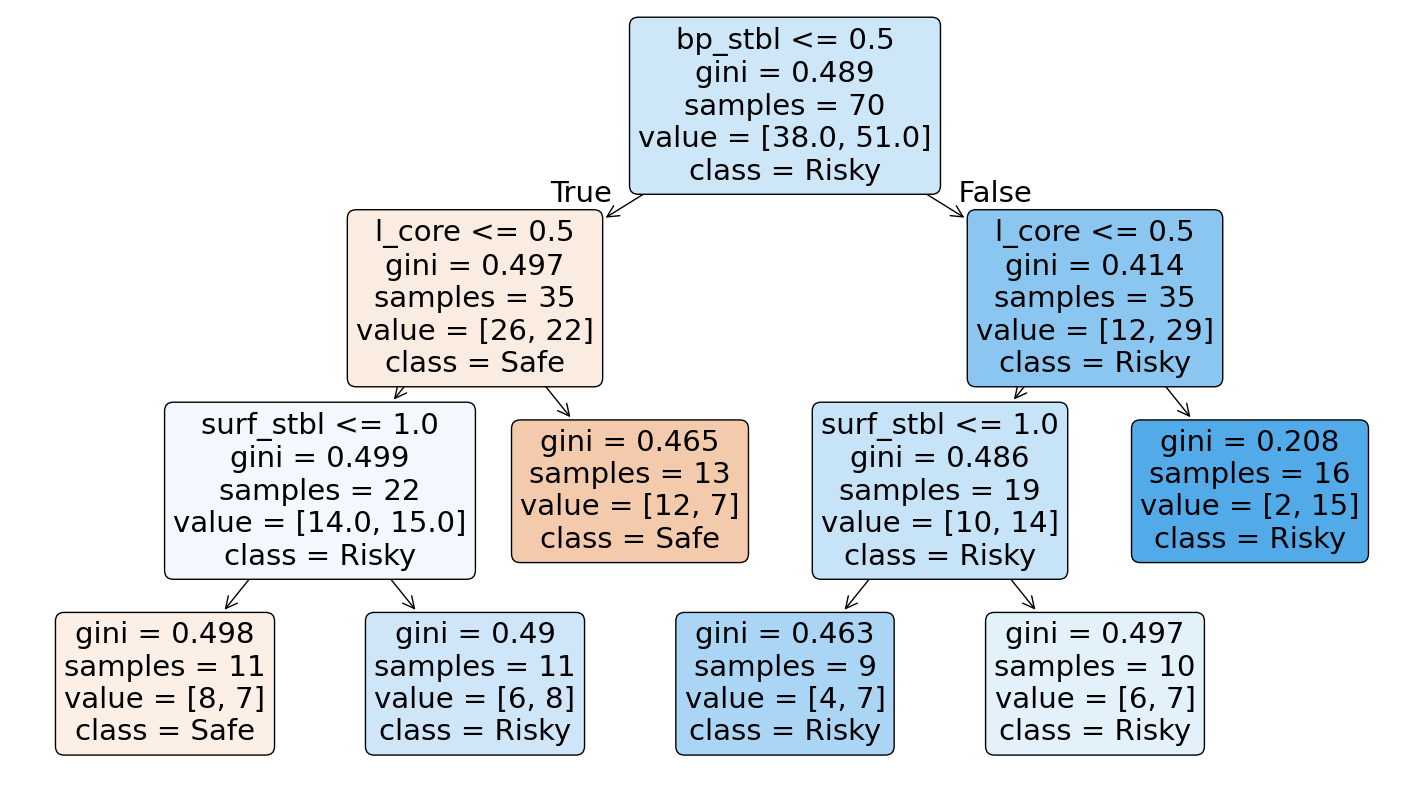

In [22]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))
plot_tree(
    dt,
    feature_names=X.columns,
    class_names=["Safe", "Risky"],
    filled=True,
    rounded=True
)
plt.show()
